In [17]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from torchvision import models
from torchvision import transforms
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [18]:
if(os.path.split(os.getcwd())[1] == "CBIR"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

cuda = False

Current Working Directory: progettoVIPM


In [19]:
from utils.loadersAndEnums import datasets
from utils.loadersAndEnums import networks
from utils.loadersAndEnums import ImageDataset
from utils.extractNeuralFeatures import extract_features

In [21]:
chosen_net = networks.ALEXNET
linear_layers_to_remove = 2
X_train_t, X_train_n, y_train, X_test_t, X_test_n, y_test, fine_tune_layers, _ = extract_features(train_set=datasets.TRAINING_LABELED,
                                                                                            test_set=datasets.TEST,
                                                                                            network=chosen_net,
                                                                                            layers_to_remove=linear_layers_to_remove, 
                                                                                            cuda=cuda)
#print("Original classification layers:{}".format(chosen_net.value[1].classifier[:]))
#print("---------------------------------------------------------------------------------")
#print("Classification layers to fine tune:{}".format(fine_tune_layers[:]))

Did not find an existing set of features in: ./Storage/neural_features/Train_AlexNet_minus2_train_small.npy
Extracting features directly to cpu:


100%|██████████| 5020/5020 [01:58<00:00, 42.20it/s]


---------------------------------------------------------------------------------
Done feat extraction, total n° of istances in Train: 5020
Feature vector shape of Train: (5020, 4096)
Label vector shape of Train: (5020,)
---------------------------------------------------------------------------------
Did not find an existing set of features in: ./Storage/neural_features/Test_AlexNet_minus2_val_set.npy
Extracting features directly to cpu:


100%|██████████| 11994/11994 [04:51<00:00, 41.19it/s]


---------------------------------------------------------------------------------
Done feat extraction, total n° of istances in Test: 11994
Feature vector shape of Test: (11994, 4096)
Label vector shape of Test: (11994,)
---------------------------------------------------------------------------------


In [22]:
chosen_net = networks.ALEXNET
layers_to_remove = 2

#X_train_ale_t, X_train_ale_n, y_train, X_test_ale_t, X_test_ale_n, y_test, fine_tune_layers = extract_features(train_set=datasets.TRAINING_LABELED,
X_unlabled_t, X_unlabled_n, _, X_test_t, X_test_n, y_test, fine_tune_layers, _ = extract_features(train_set=datasets.TRAINING_UNLABELED,
                                                                                            test_set=datasets.TEST,
                                                                                            network=chosen_net,
                                                                                            layers_to_remove=layers_to_remove,
                                                                                            cuda=cuda)
#print("Original classification layers:{}".format(chosen_net.value[1].classifier[:]))
#print("Classification layers to fine tune:{}".format(fine_tune_layers[:]))

Did not find an existing set of features in: ./Storage/neural_features/Train_AlexNet_minus2_train_unlabeled.npy
Extracting features directly to cpu:


100%|██████████| 113455/113455 [1:00:28<00:00, 31.27it/s]


---------------------------------------------------------------------------------
Done feat extraction, total n° of istances in Train: 113455
Feature vector shape of Train: (113455, 4096)
Label vector shape of Train: (113455,)
---------------------------------------------------------------------------------
Found an existing set of features in: ./Storage/neural_features/Test_AlexNet_minus2_val_set.npy
Loading features from file:
---------------------------------------------------------------------------------
Done feat extraction, total n° of istances in Test: 11994
Feature vector shape of Test: (11994, 4096)
Label vector shape of Test: (11994,)
---------------------------------------------------------------------------------


In [53]:
from sklearn.cluster import MeanShift
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler


all_pics = np.concatenate([X_unlabled_n, X_train_n])


# Min-Max Scaling
min_max_scaler = MinMaxScaler()
normalized_features = min_max_scaler.fit_transform(all_pics)

# Standardization
standard_scaler = StandardScaler()
all_pics = standard_scaler.fit_transform(normalized_features)


In [54]:
reduced_data = PCA(n_components=2).fit_transform(all_pics)

In [55]:
reduced_data.shape

(118475, 2)

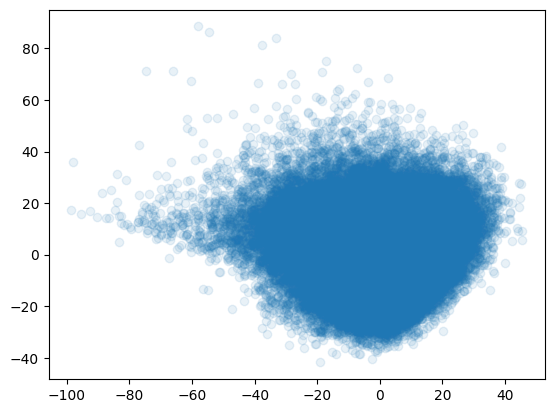

In [56]:
import matplotlib.pyplot as plt
x=reduced_data[:, 0]
y=reduced_data[:, 1]
plt.scatter(x, y, alpha=0.1)
plt.show()

In [57]:
reduced_data = PCA(n_components=3).fit_transform(all_pics)

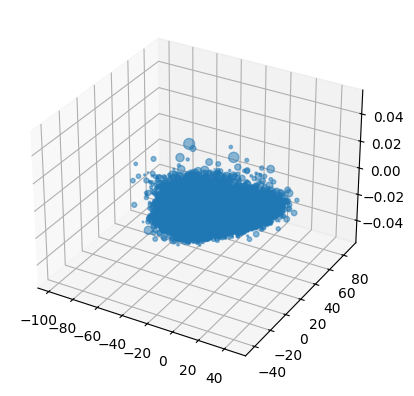

In [58]:
x=reduced_data[:, 0]
y=reduced_data[:, 1]
z=reduced_data[:, 2]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

plt.scatter(x, y, z, alpha=0.5)
plt.show()

In [59]:
reduced_data = PCA(n_components=10).fit_transform(all_pics)

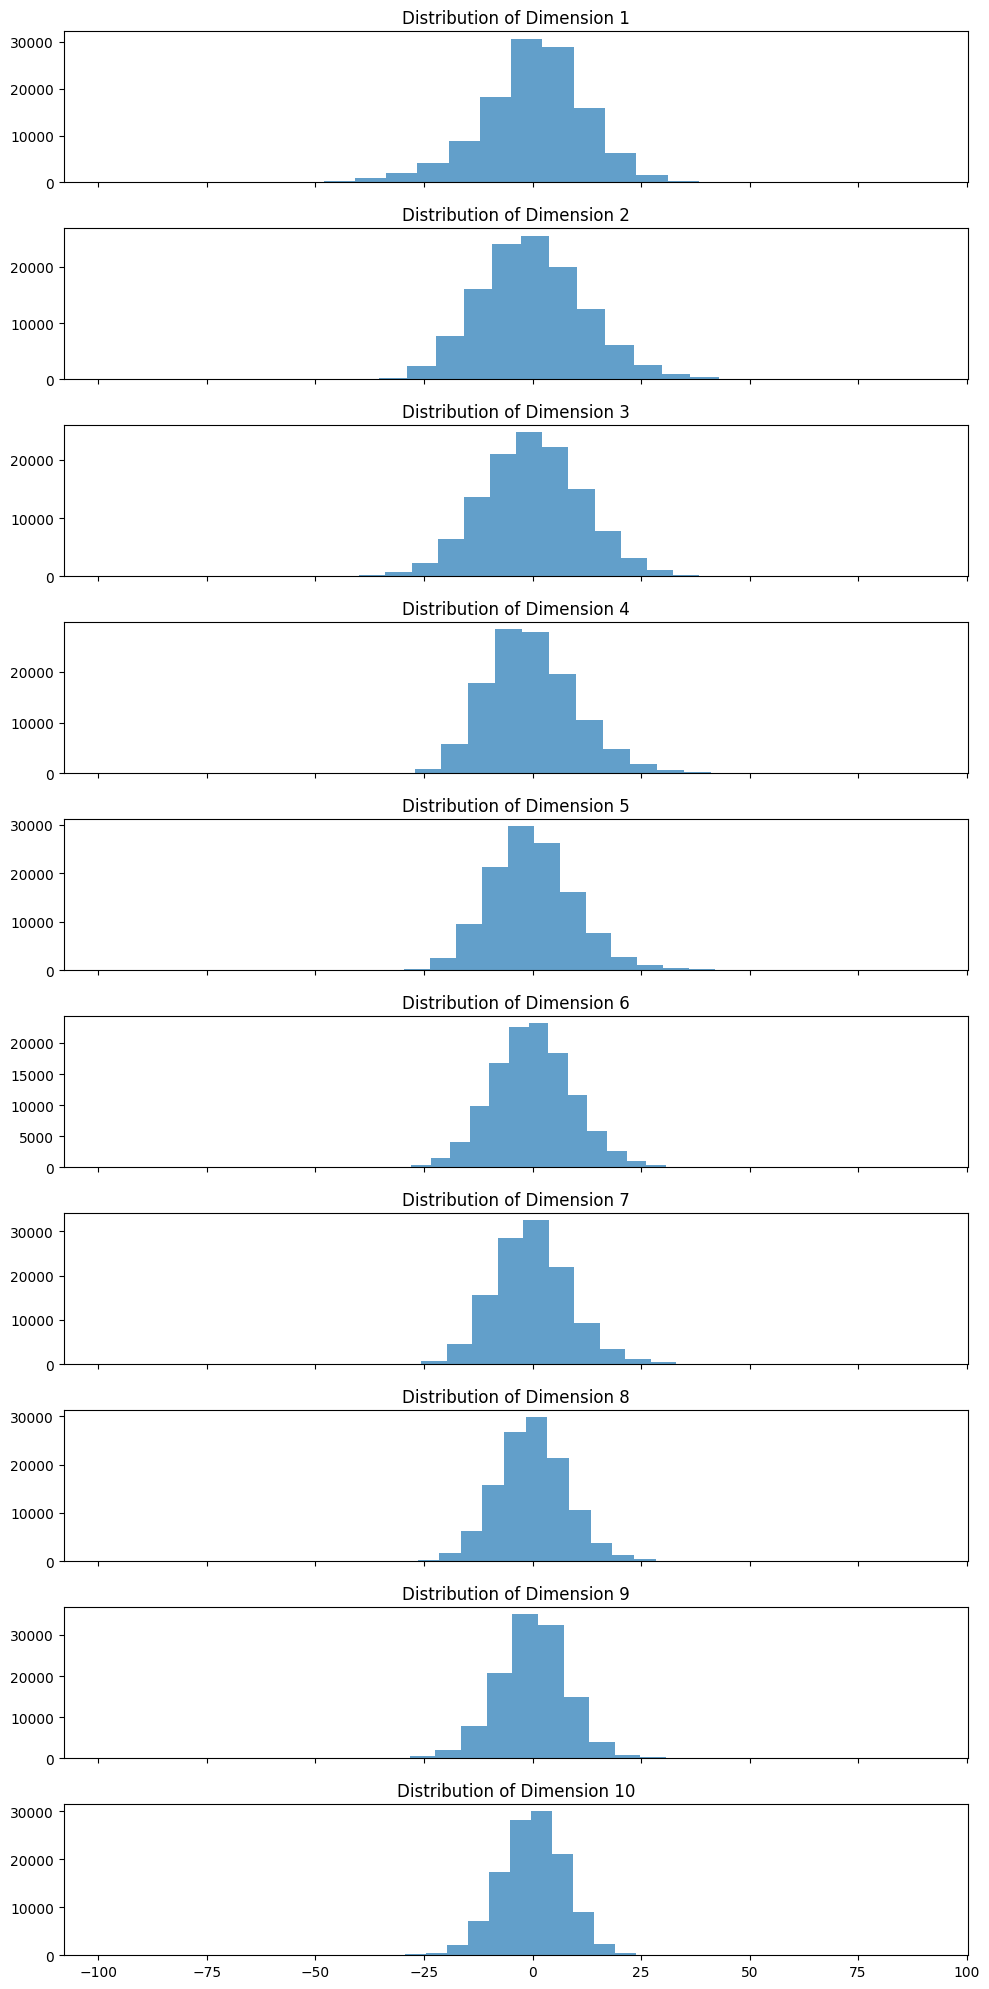

In [60]:
num_samples, n_dimensions = reduced_data.shape

# Create a figure and a set of subplots
fig, axes = plt.subplots(n_dimensions, 1, figsize=(10, 2*n_dimensions), sharex=True)

# Plot the distribution of each dimension
for i in range(n_dimensions):
    axes[i].hist(reduced_data[:, i], bins=20, alpha=0.7)
    axes[i].set_title(f'Distribution of Dimension {i+1}')

plt.tight_layout()
plt.show()


In [61]:

#import pickle
#with open(b"reduced_data_10_comp.obj", "wb") as f:
#    pickle.dump(reduced_data, f)
#clustering = MeanShift(n_jobs=-1).fit(reduced_data) 

In [62]:
from sklearn.metrics.pairwise import pairwise_distances
d = pairwise_distances(X_train, X_val, metric='cityblock', n_jobs=-1)#1o argument->le query, 2o->le pic da "indicizazre"

In [63]:
print(d.shape)
print(d.dtype)

(4518, 502)
float32


In [64]:

def sort_indices_by_distance(matrix):
    sorted_indices = [np.argsort(row).tolist() for row in matrix]
    return sorted_indices


def threshold_matrix(matrix, threshold):  #ha senso? se sono valori grandi sono in fondo al ranking tanto..
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if matrix[i][j]>=threshold:
                matrix[i][j]=np.iinfo(matrix.dtype).max
    return matrix

#per esempio:
D = np.array([
    [0, 2, 3, 4],
    [2, 0, 1, 5],
    [3, 1, 0, 6],
    [4, 5, 6, 0]
])
#print(threshold_matrix(D, 5))
#sorted_indices = sort_indices_by_distance(D)#[[0, 1, 2, 3], [1, 2, 0, 3], [2, 1, 0, 3], [3, 0, 1, 2]]

sorted_indices = sort_indices_by_distance(d)

